Set up
===

In [107]:
import pandas as pd
data_directory = '../data/'

In [108]:
time_series_metadata = pd.DataFrame(columns=['Units', 'Source'])
time_series_metadata.index.name='Name'

Bring in Farmer and Lafond data
===

In [109]:
df = pd.read_csv(data_directory+'original/Farmer_Lafond_Data.csv', index_col=0)

for col in df.columns:
    time_series_metadata.ix[col, 'Units'] = df[col].iloc[0]
    time_series_metadata.ix[col, 'Source'] = 'Farmer_Lafond'
    time_series_metadata.ix[col, 'Type'] = 'Price'


time_series = 1/df.iloc[2:].astype('float')

for col in df.columns:
    time_series_metadata.ix[col, 'n'] = time_series[col].notnull().sum()
    time_series_metadata.ix[col, 'Start'] = time_series[col].dropna().index[0]
    time_series_metadata.ix[col, 'Stop'] = time_series[col].dropna().index[-1]    

Manual edits
----

In [110]:
time_series_metadata.ix['Automotive (US)', 'Type'] = 'Performance'
time_series_metadata.ix['Milk (US)', 'Type'] = 'Performance'

Bring in Magee et al data
===

In [111]:
from os import listdir
from numpy import sort
data_directories = sort(listdir(data_directory+'original/Magee_et_al_Data/'))

In [112]:
for d in data_directories:
    if d.startswith('.'):
        continue
    files = sort(listdir(data_directory+'original/Magee_et_al_Data/%s/'%d))
    for f in files:
        if f.endswith('.xlsx'):
            df = pd.read_excel(data_directory+'original/Magee_et_al_Data/%s/%s'%(d,f),sheetname='rawdata',index_col=0)
            col = f.split('_v1')[0].replace('.xlsx','')
            df = df[df.columns[0]]
            time_series_metadata.ix[col, 'Units'] = df.name
            time_series_metadata.ix[col, 'Source'] = 'Magee_et_al'
            time_series_metadata.ix[col, 'n'] = df.dropna().shape[0]
            time_series_metadata.ix[col, 'Start'] = df.dropna().index[0]
            time_series_metadata.ix[col, 'Stop'] = df.dropna().index[-1]
            df.name = col
            df.index = df.index.astype('float')
            df = df.groupby(level=0).min()
            units = time_series_metadata.ix[col, 'Units'].lower()
            if "cost" in units or "price" in units or "usd" in units or "$" in units or "dollar" in units:
                time_series_metadata.ix[col, 'Type'] = 'Price'
            else:
                time_series_metadata.ix[col, 'Type'] = 'Performance'
            time_series = time_series.join(df, how='outer')

Manual edits
----

In [113]:
time_series_metadata = time_series_metadata.rename(index={'AC_electricity_transmission_powered_distance_per_$_wkm_$':
                           'AC_electricity_transmission_powered_distance_per_cost_wkm_$'})

time_series = time_series.rename(columns={'AC_electricity_transmission_powered_distance_per_$_wkm_$':
                           'AC_electricity_transmission_powered_distance_per_cost_wkm_$'})

Convert Performance to Non-Dominated Values
====

In [114]:
for tech in time_series.columns:
    if time_series_metadata.ix[tech, 'Type'] == 'Performance':
        time_series[tech] = time_series[tech].dropna().cummax().drop_duplicates().reindex(time_series.index) #Non-dominated
        time_series_metadata.ix[tech, 'n'] = time_series[tech].notnull().sum()

In [115]:
time_series.to_csv(data_directory+'time_series.csv')
time_series_metadata.to_csv(data_directory+'time_series_metadata.csv')

Populating the interactive namespace from numpy and matplotlib


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


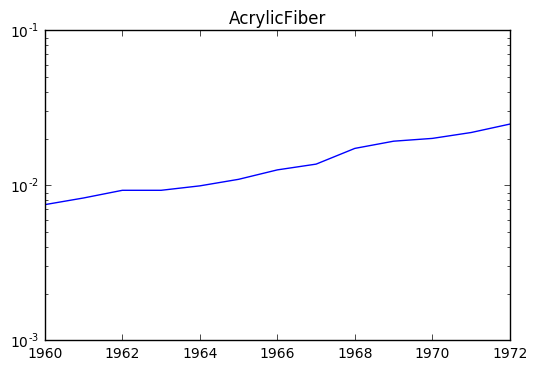

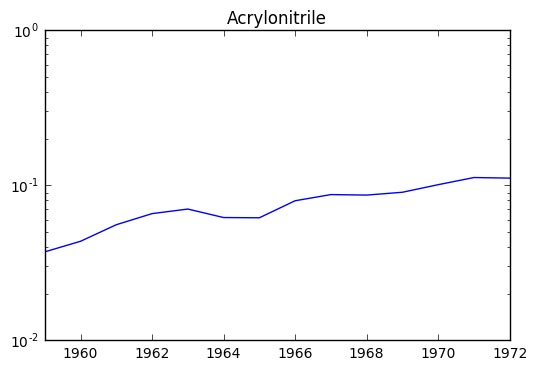

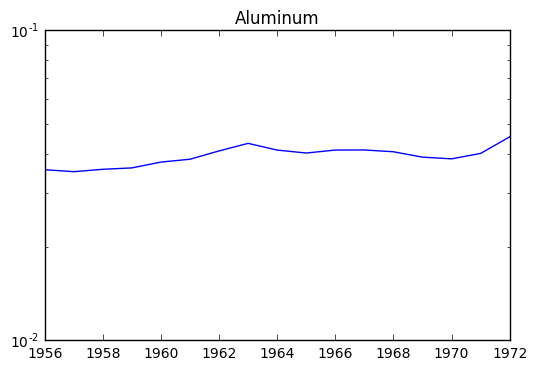

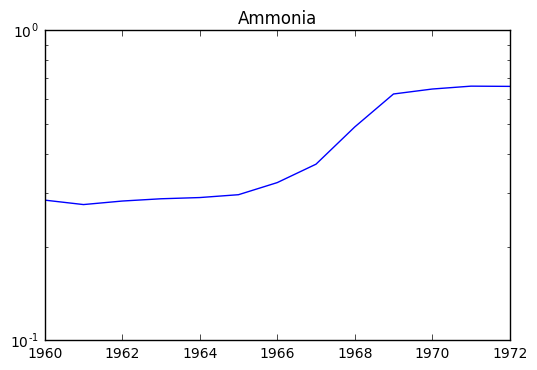

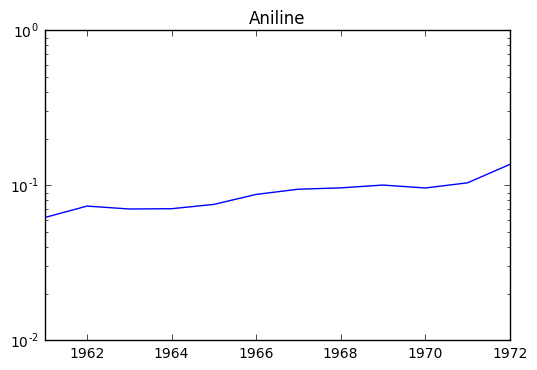

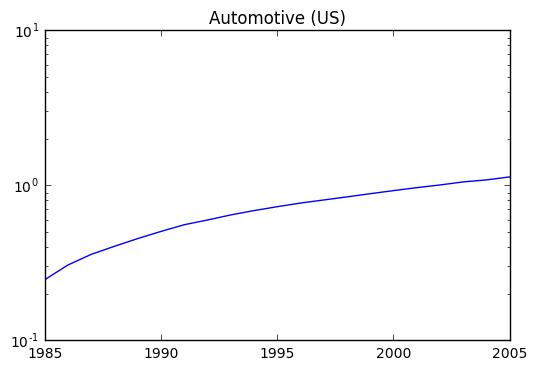

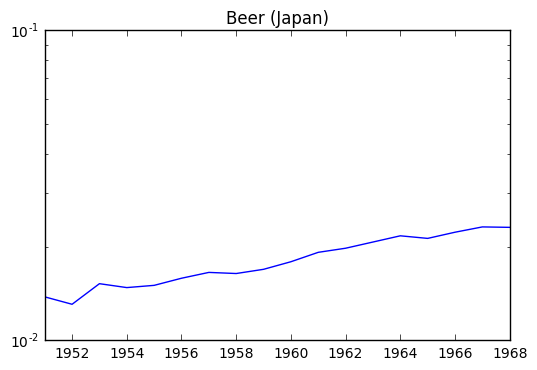

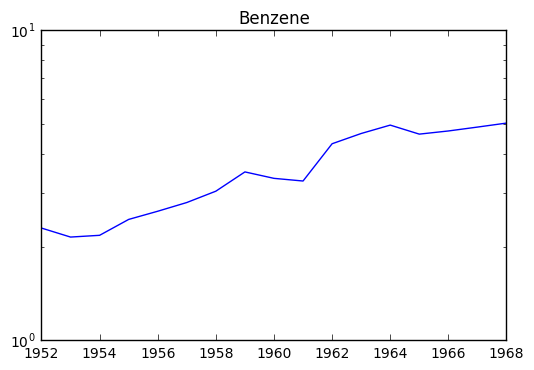

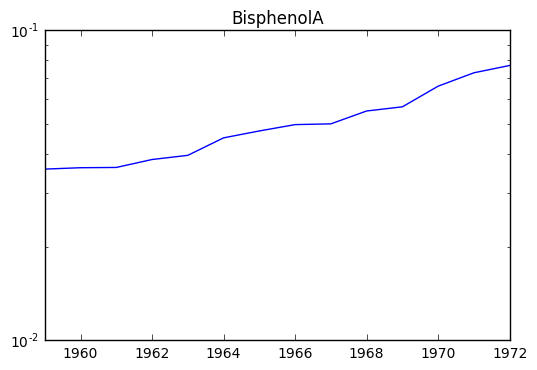

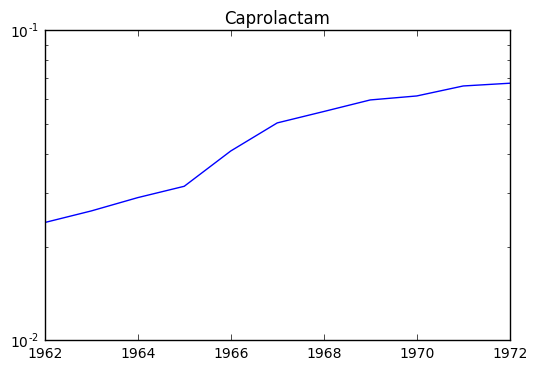

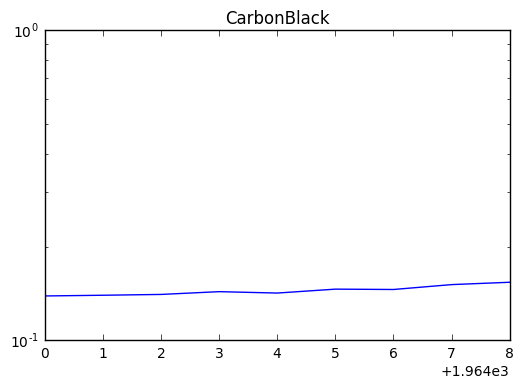

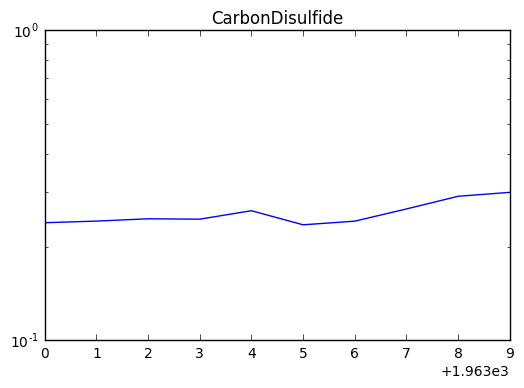

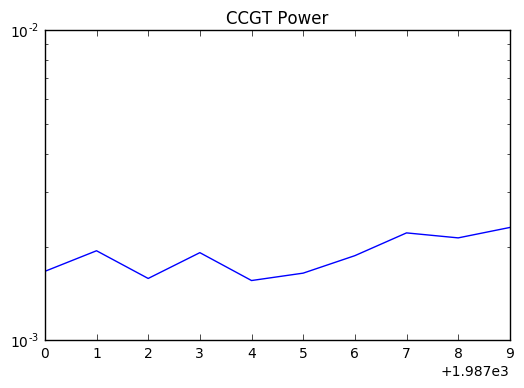

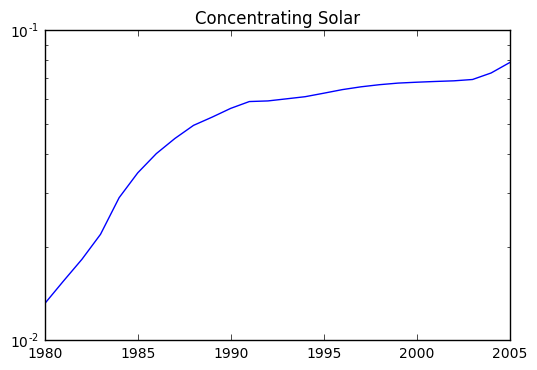

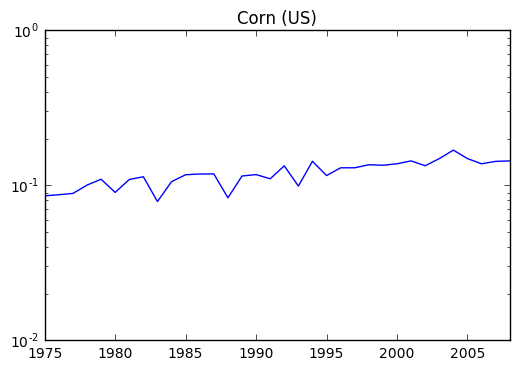

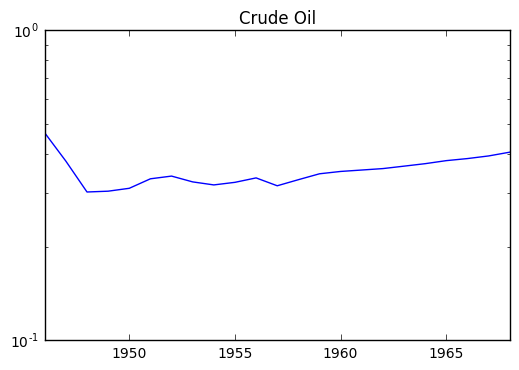

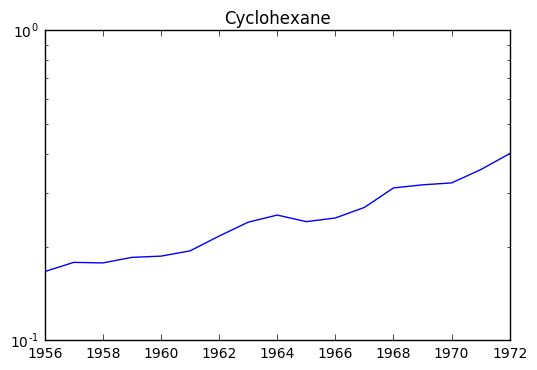

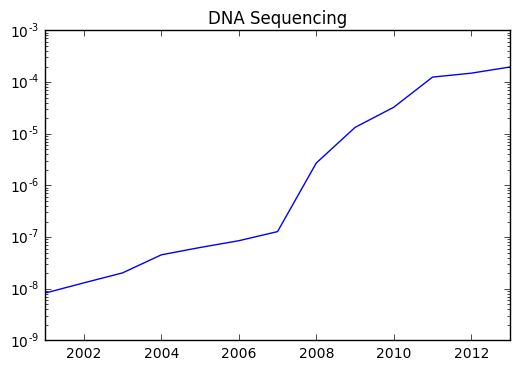

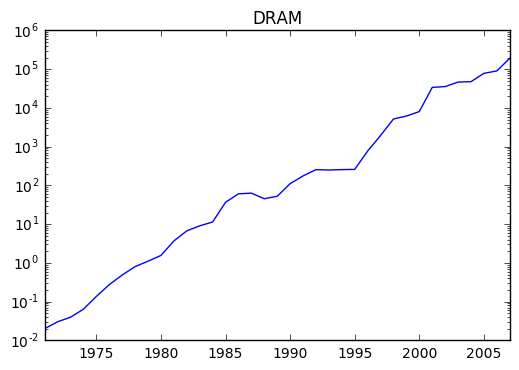

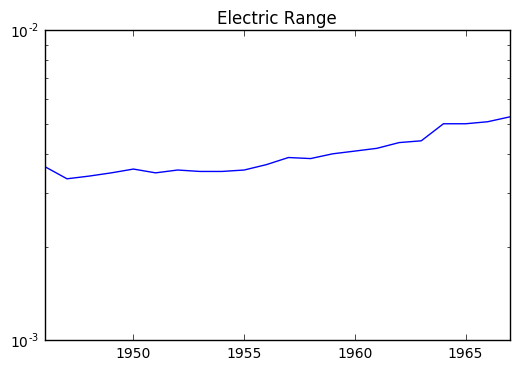

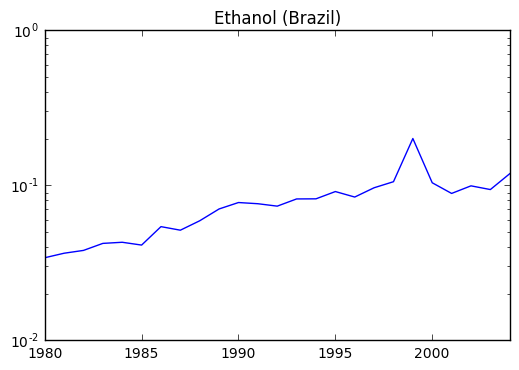

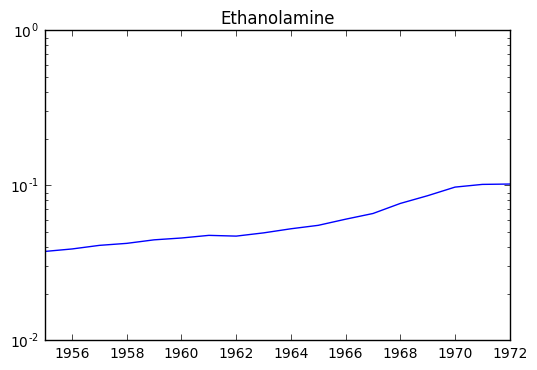

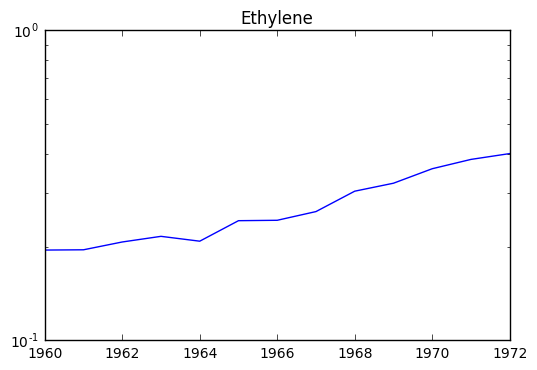

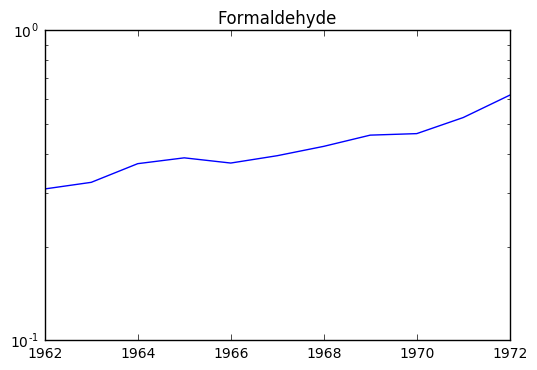

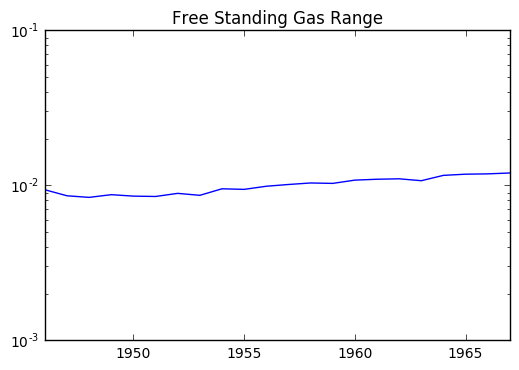

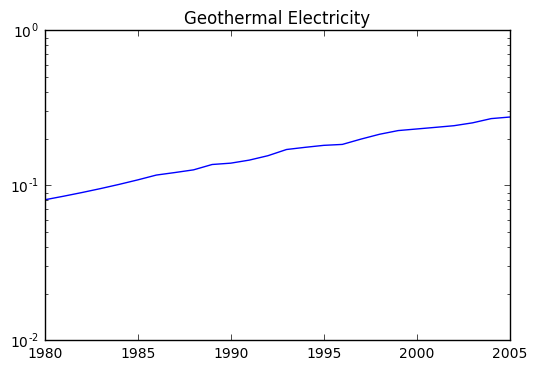

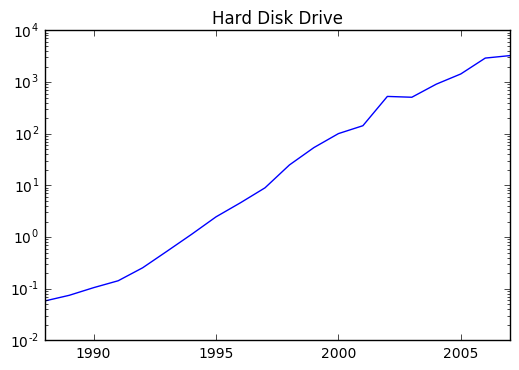

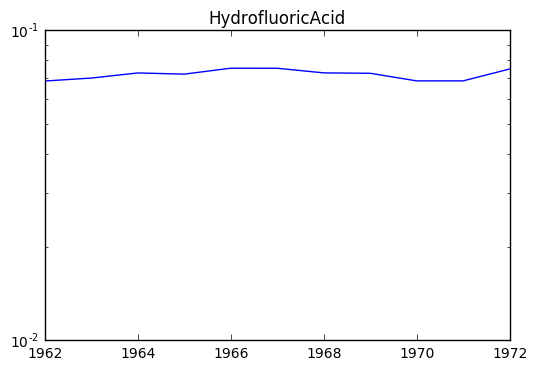

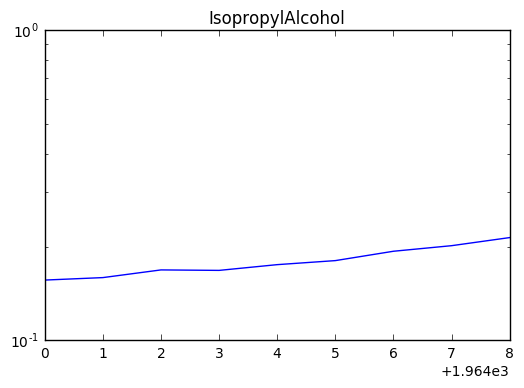

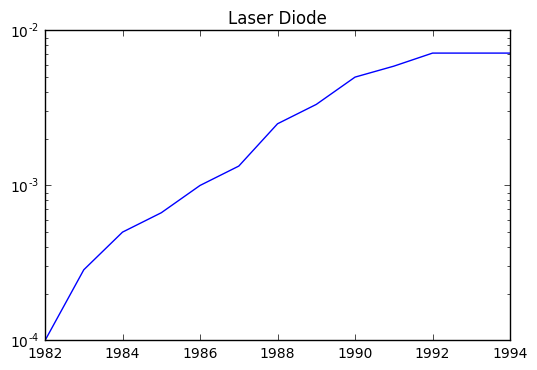

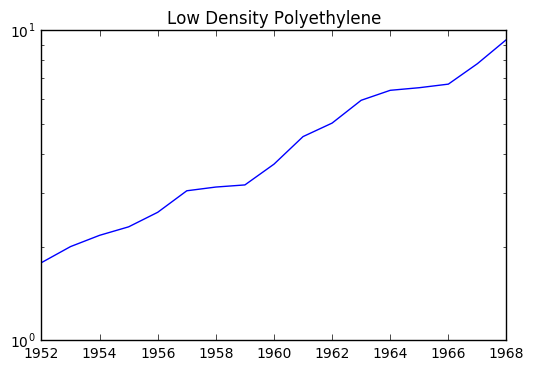

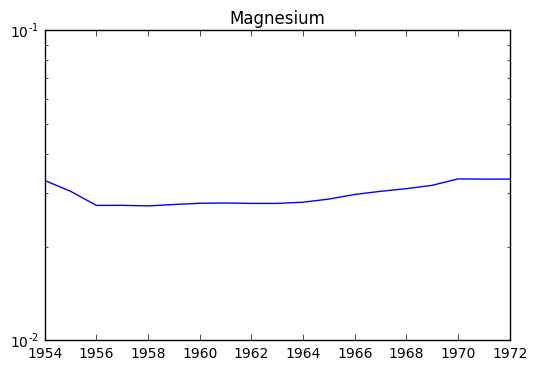

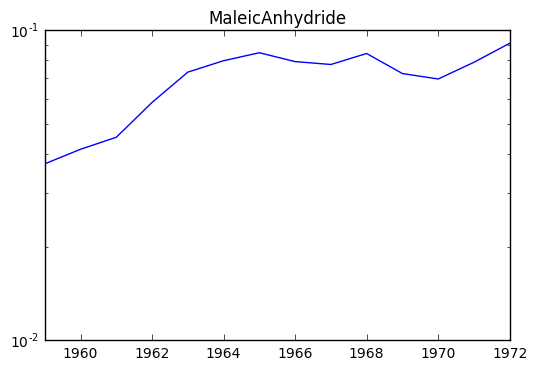

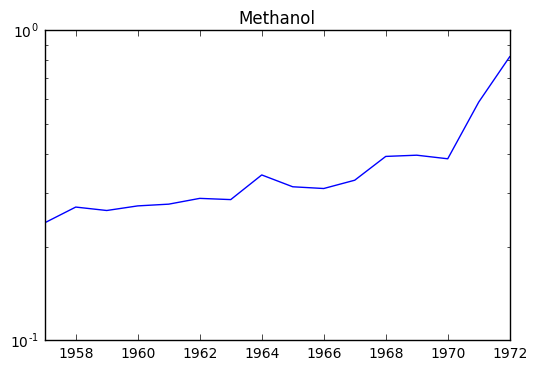

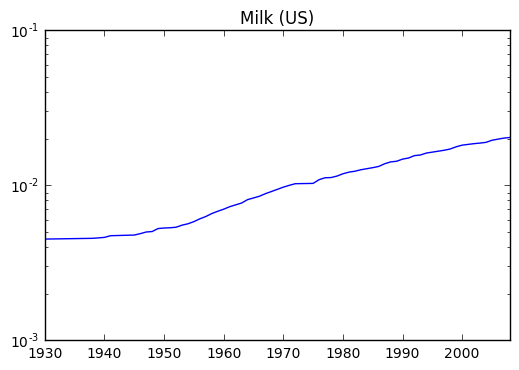

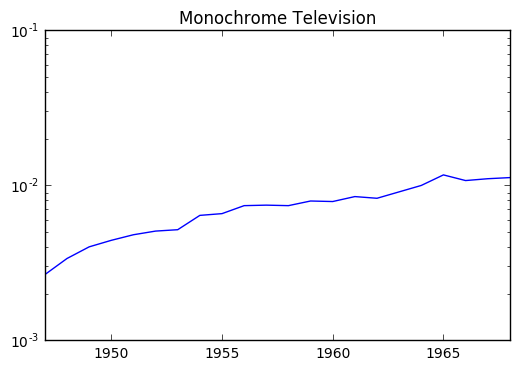

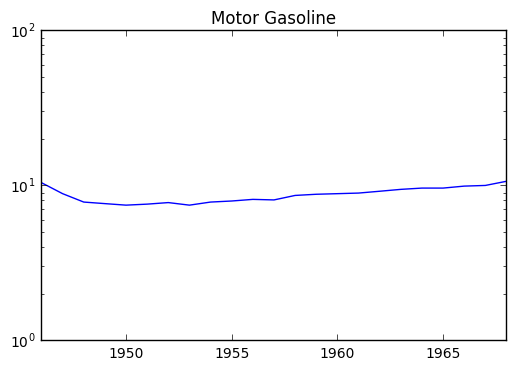

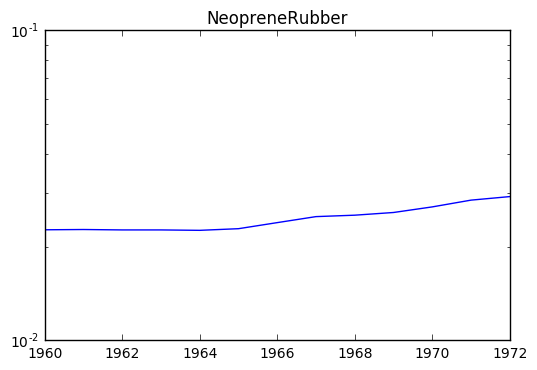

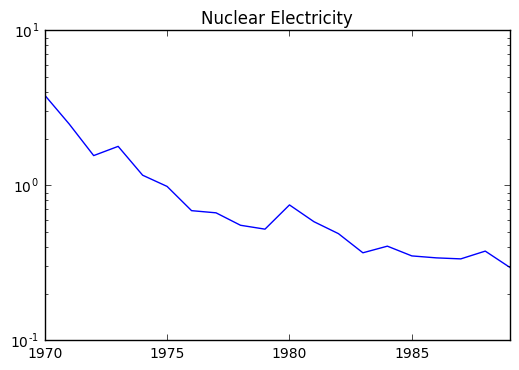

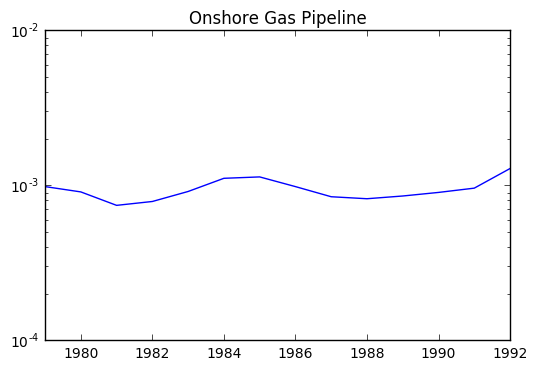

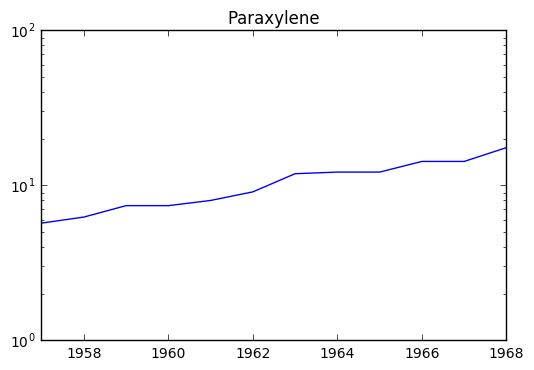

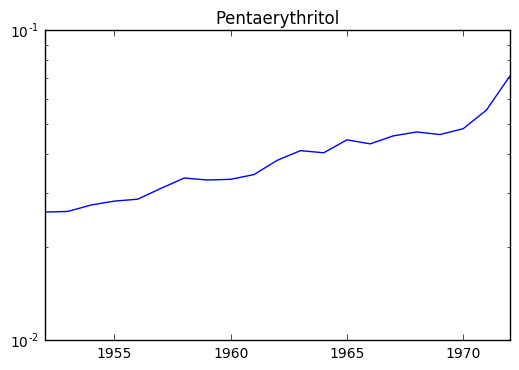

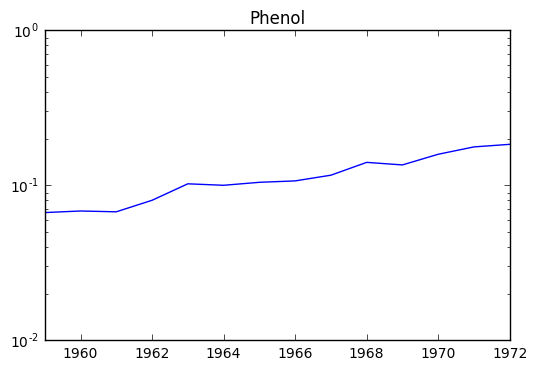

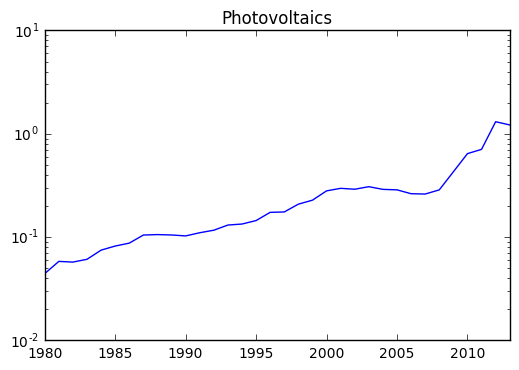

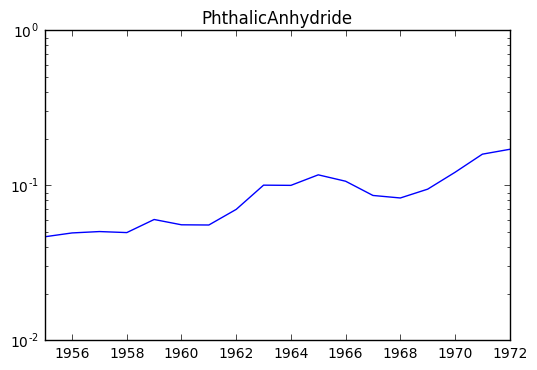

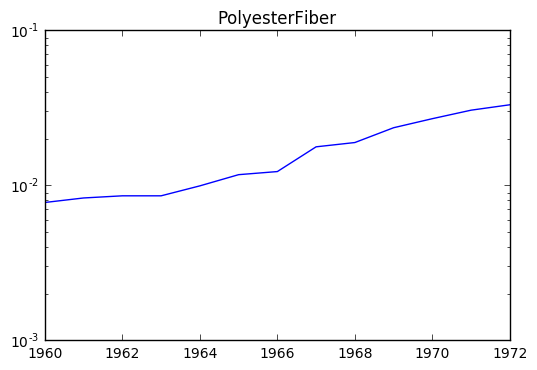

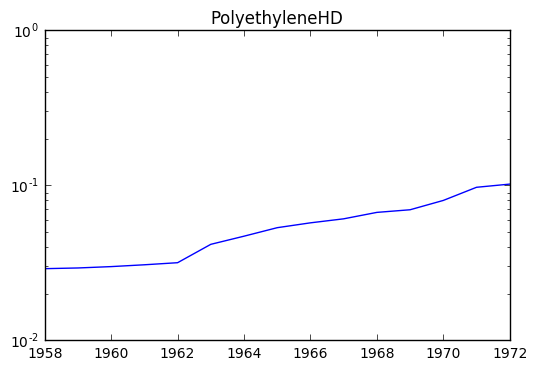

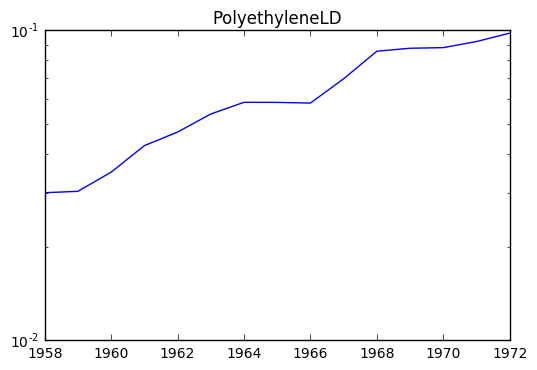

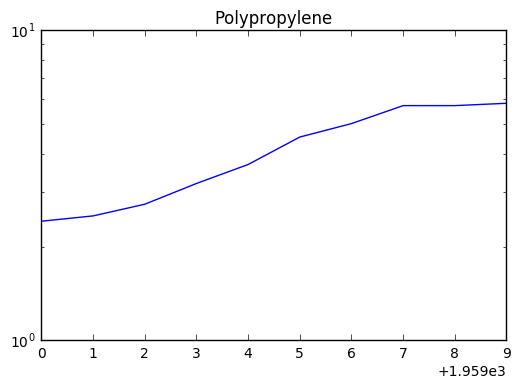

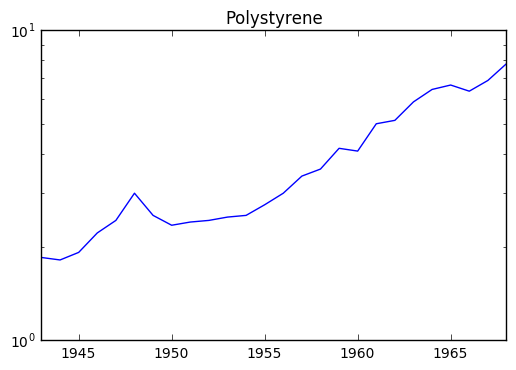

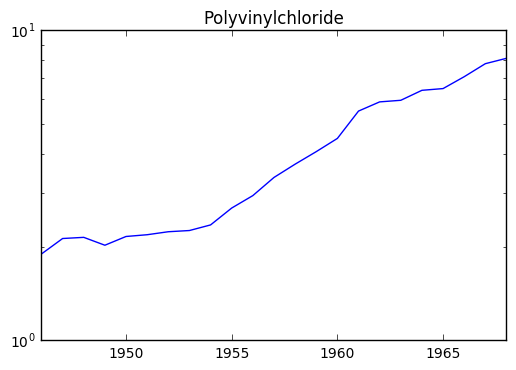

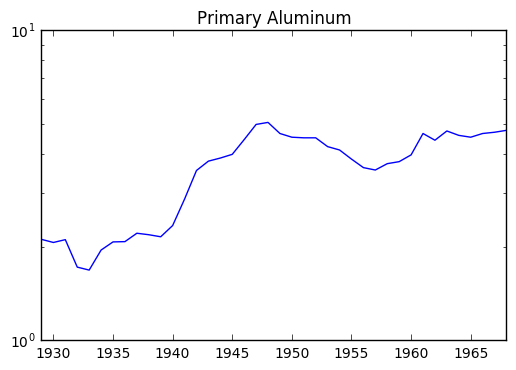

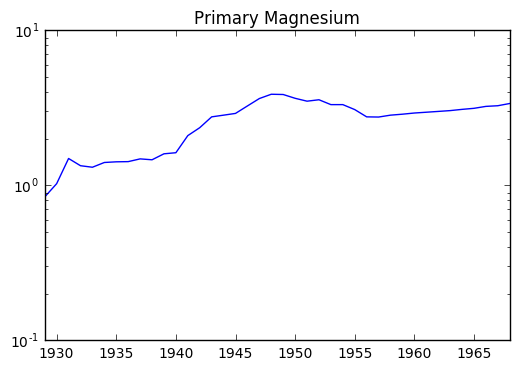

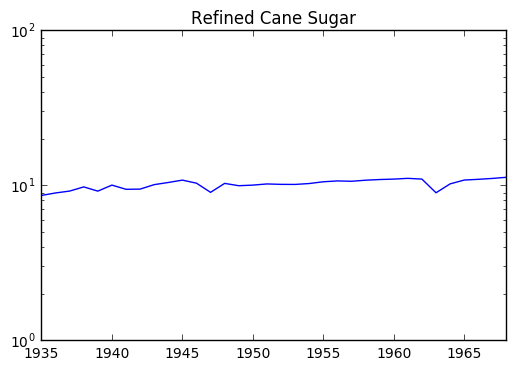

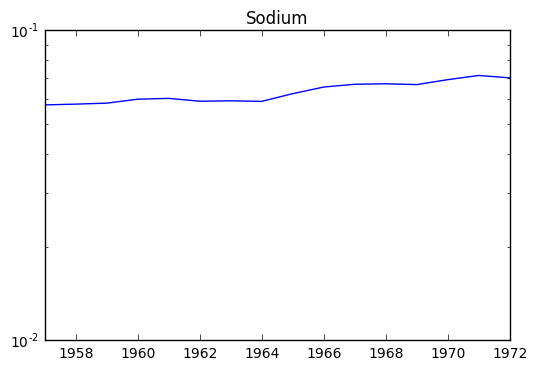

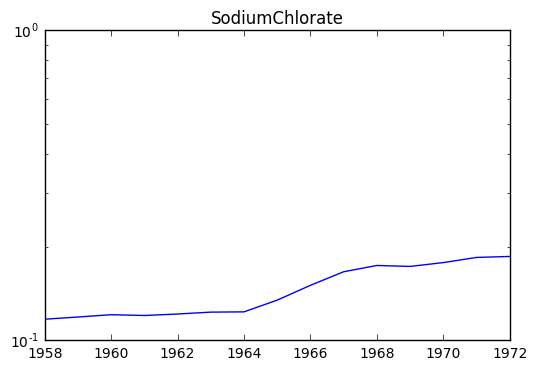

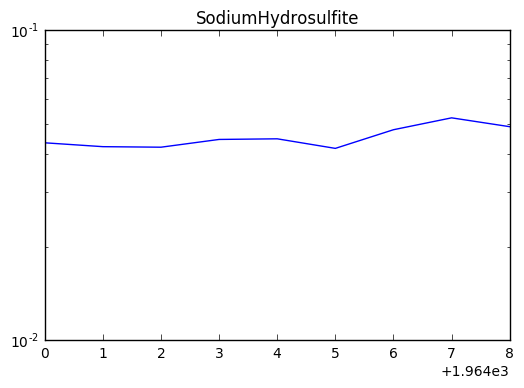

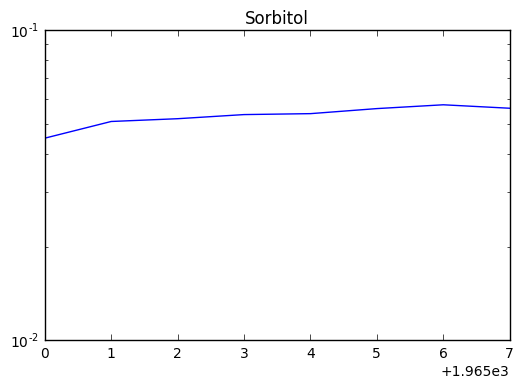

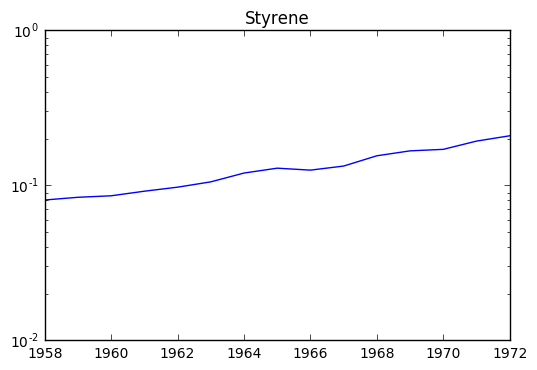

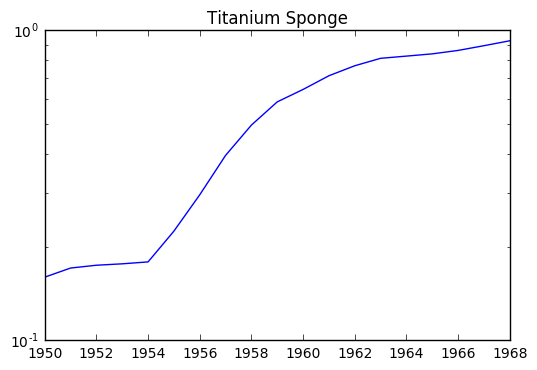

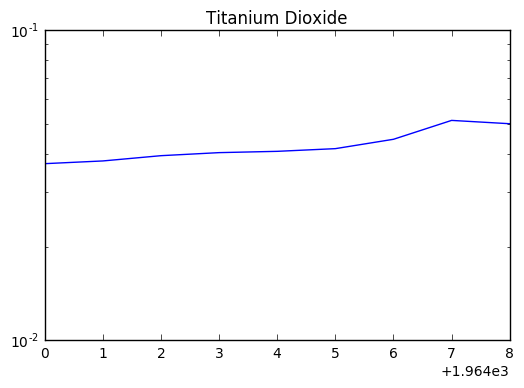

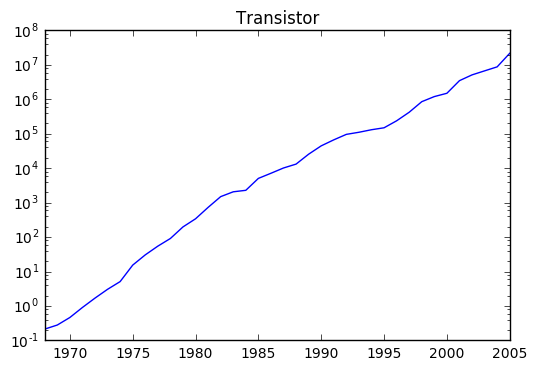

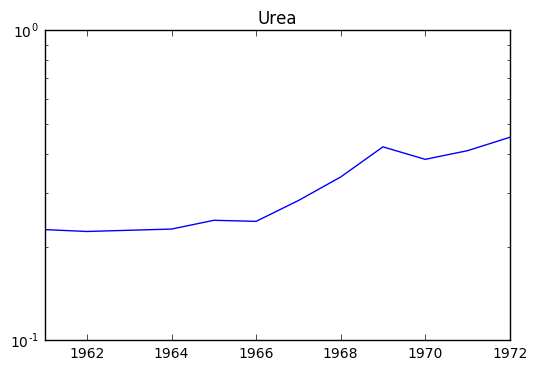

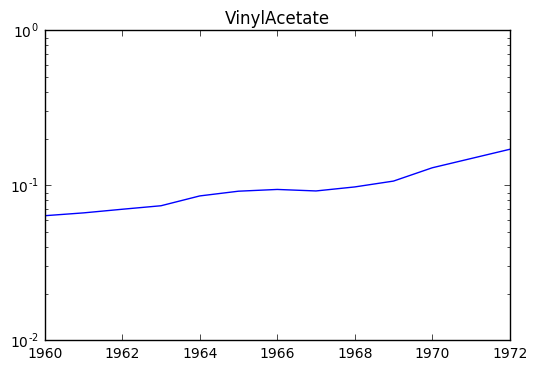

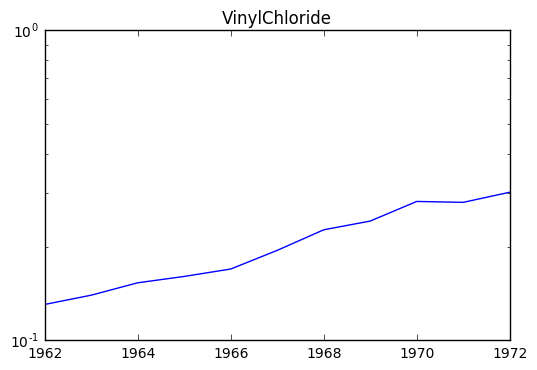

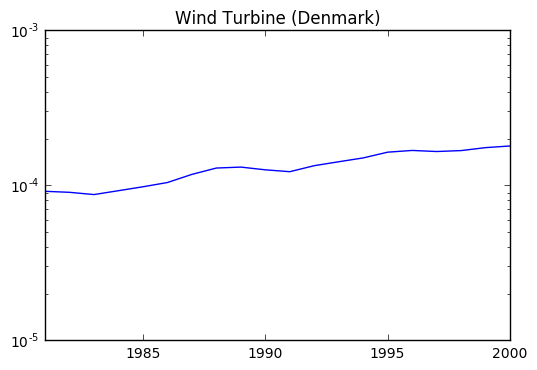

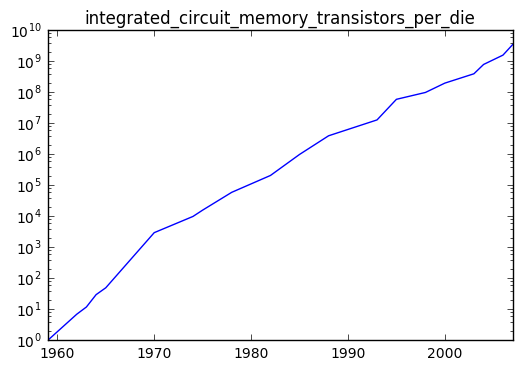

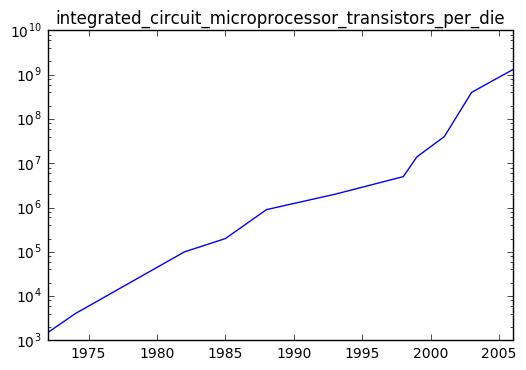

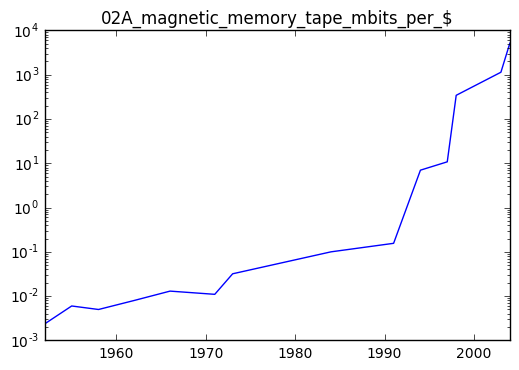

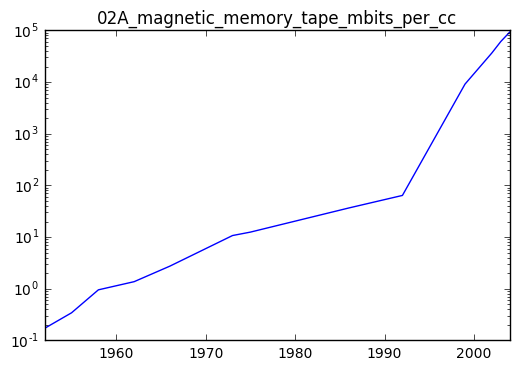

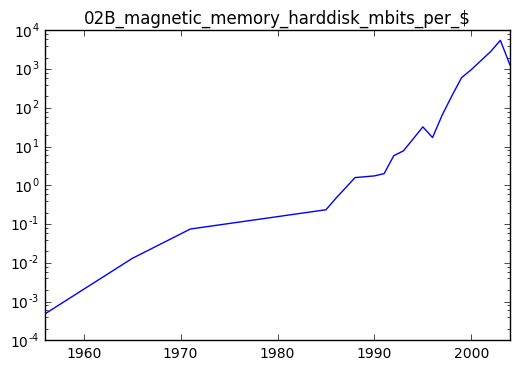

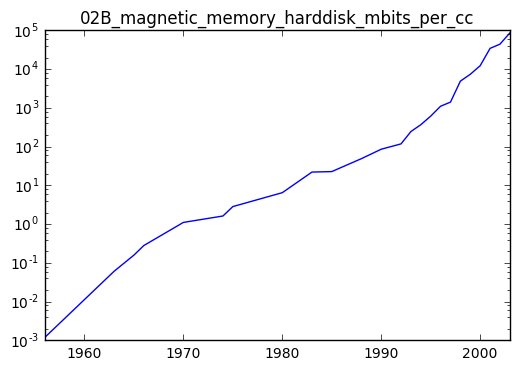

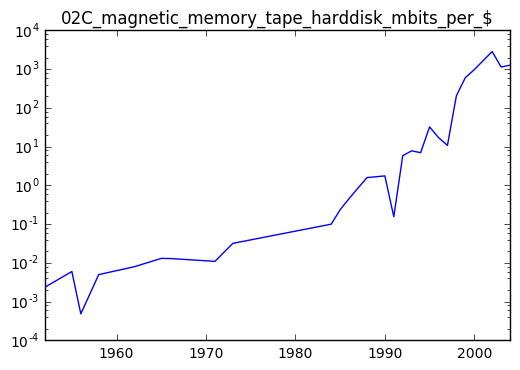

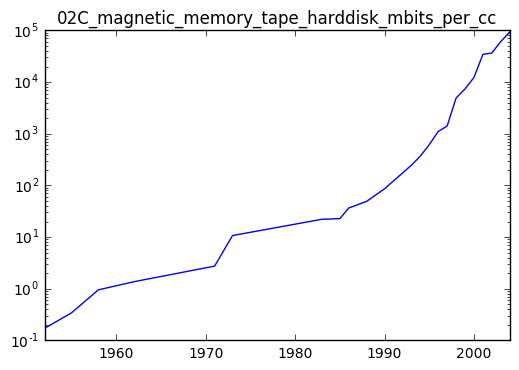

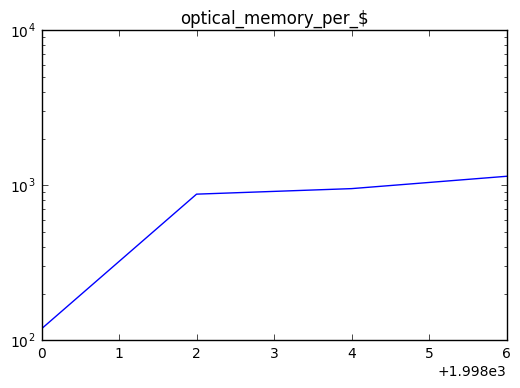

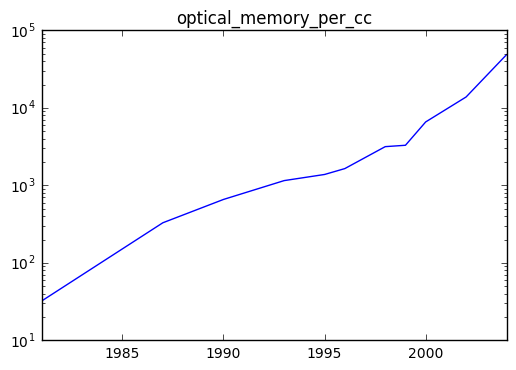

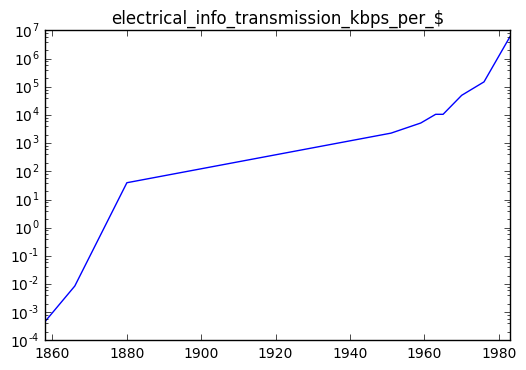

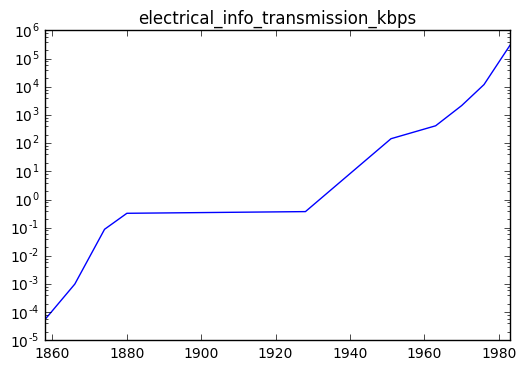

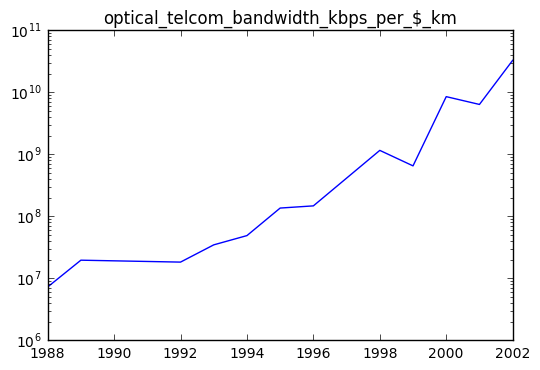

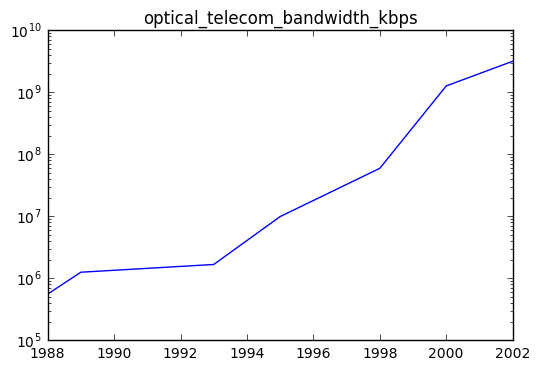

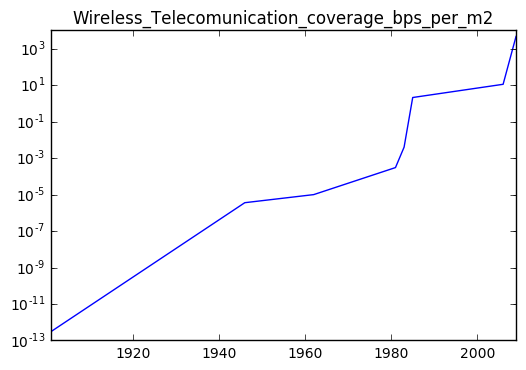

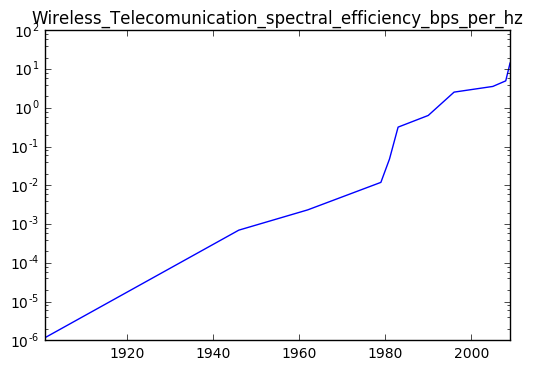

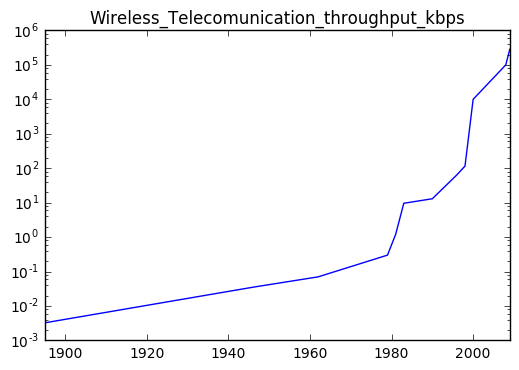

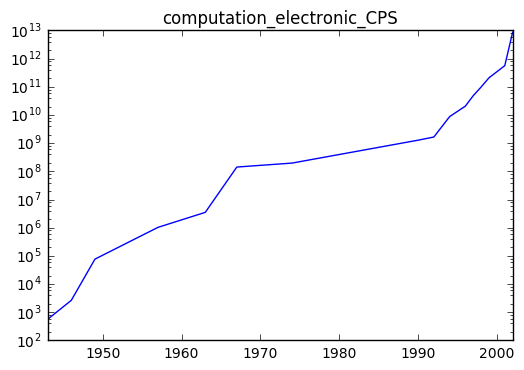

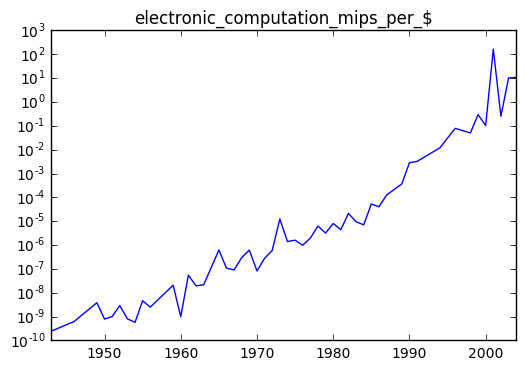

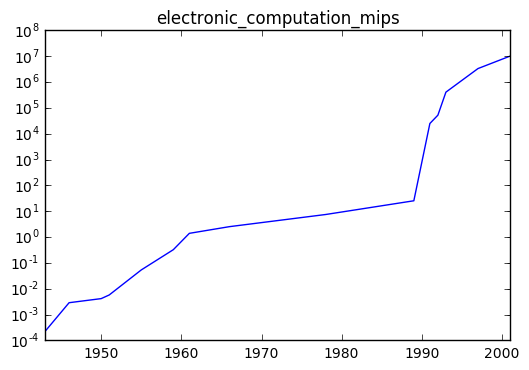

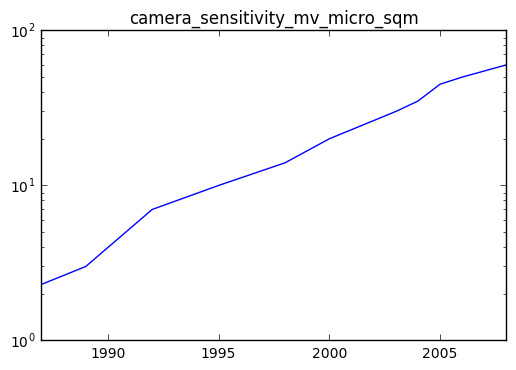

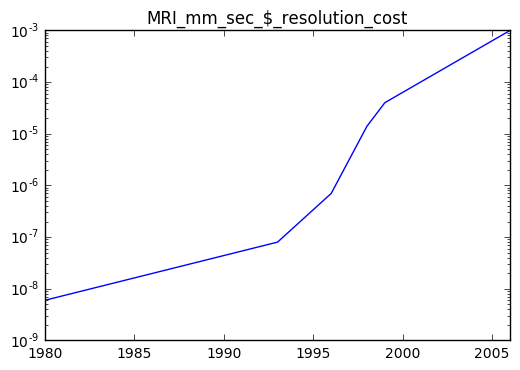

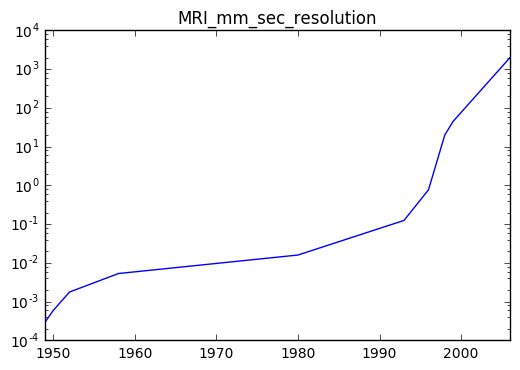

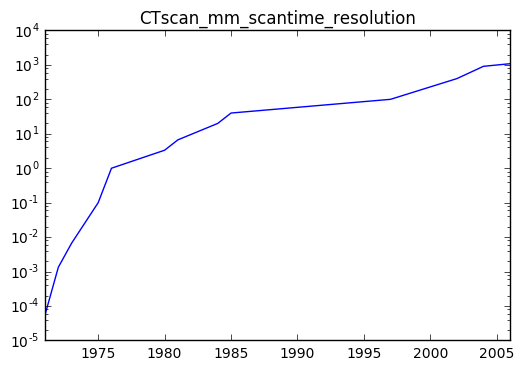

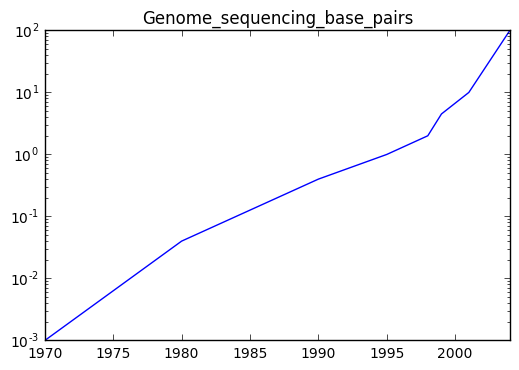

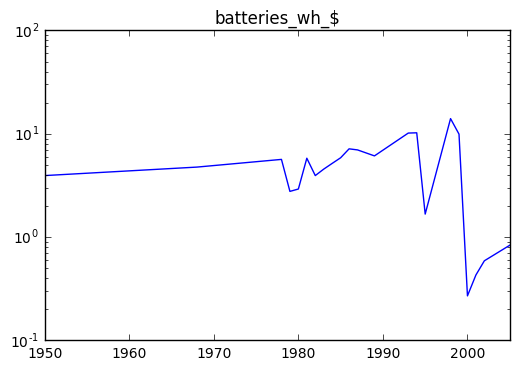

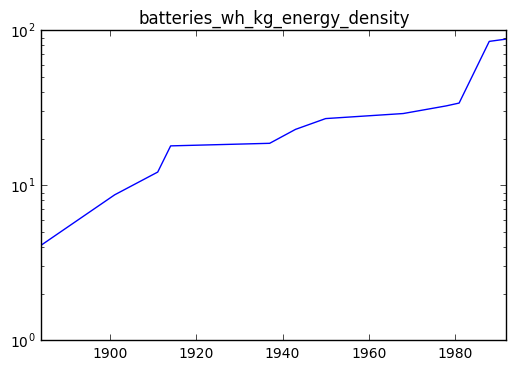

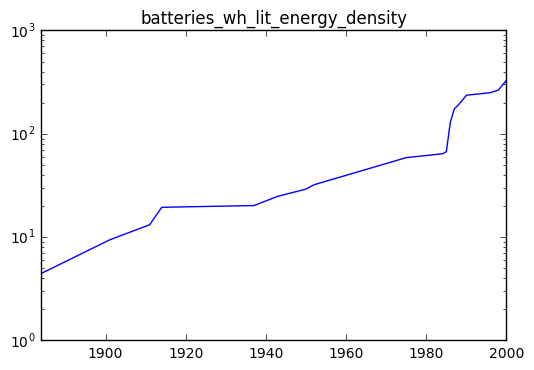

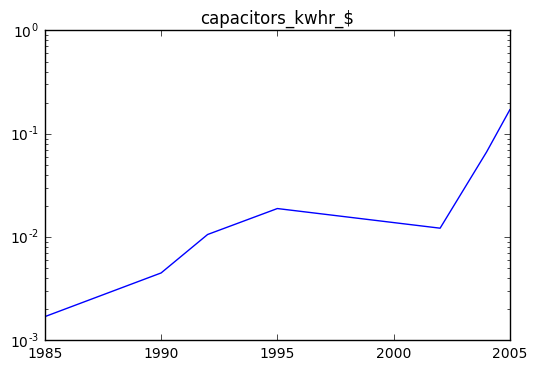

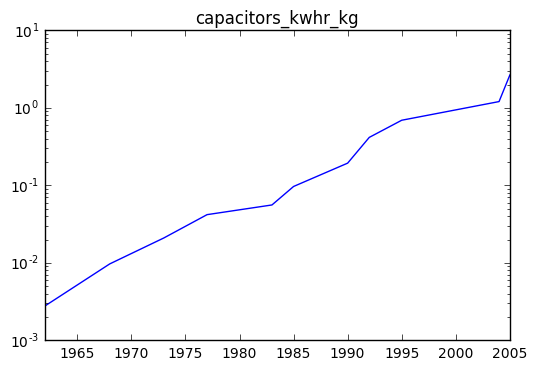

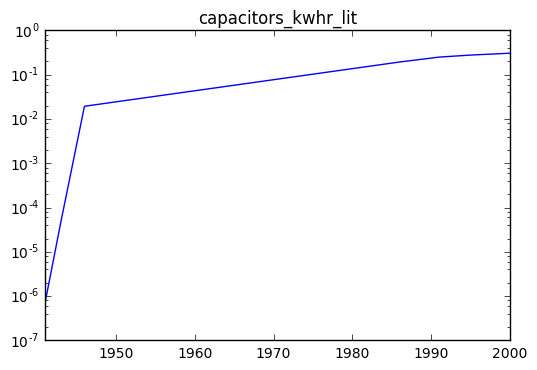

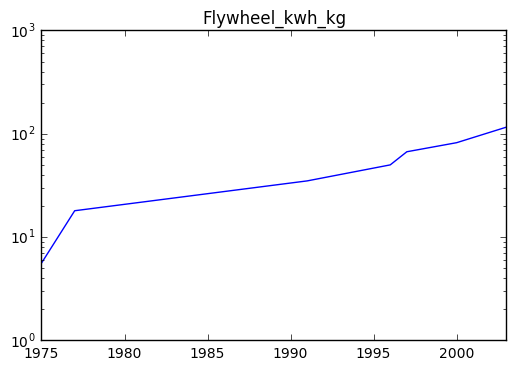

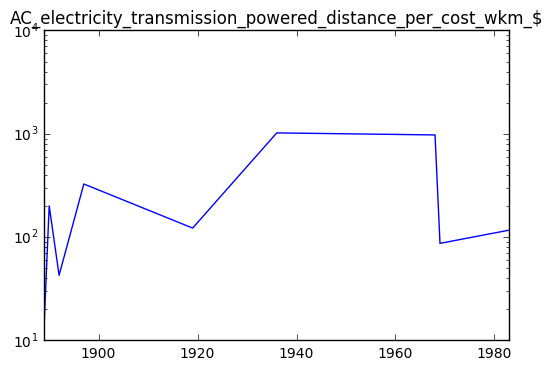

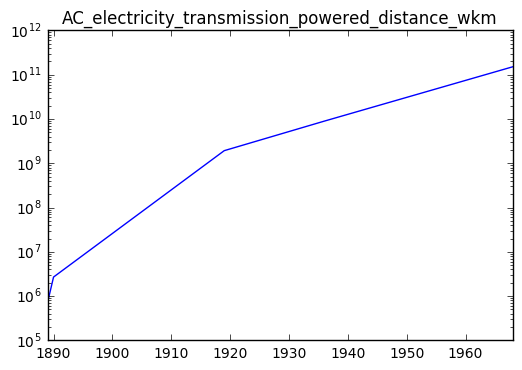

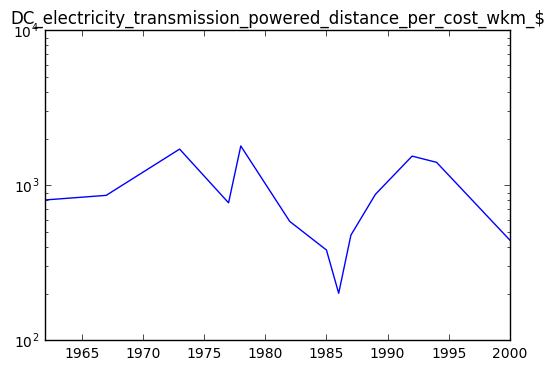

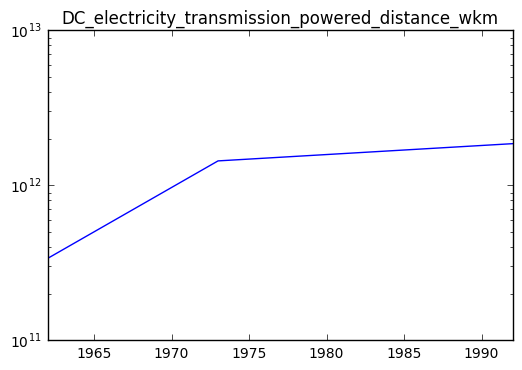

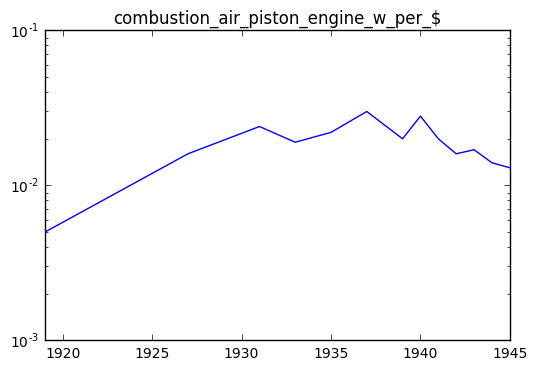

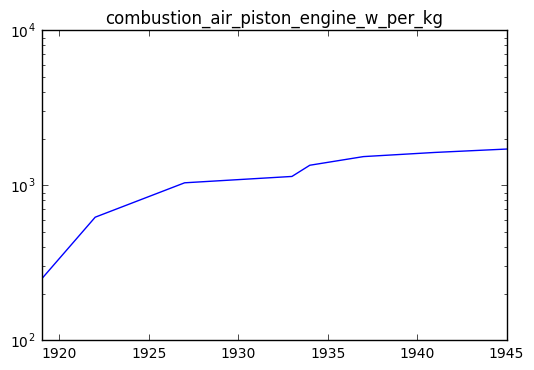

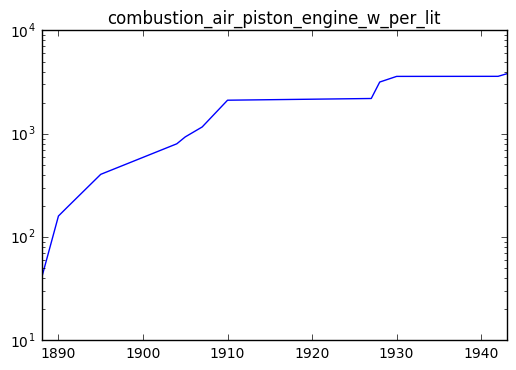

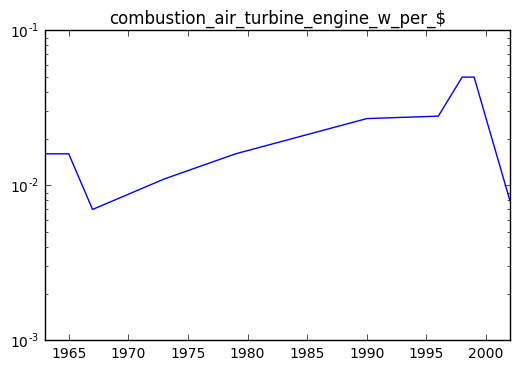

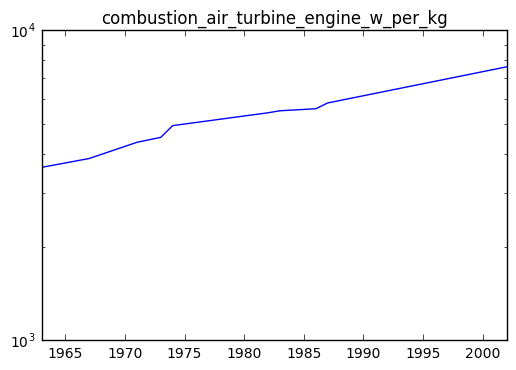

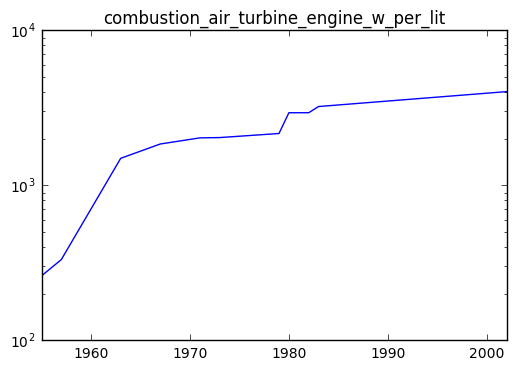

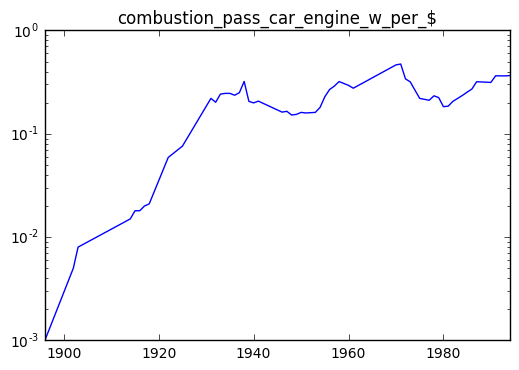

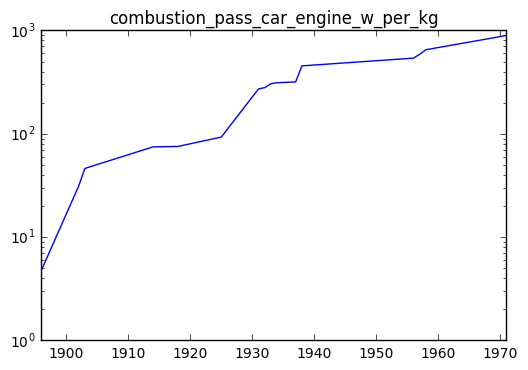

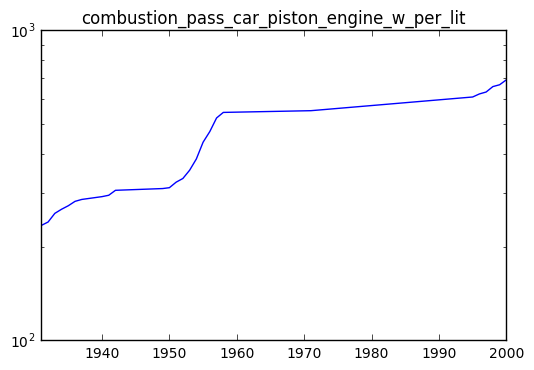

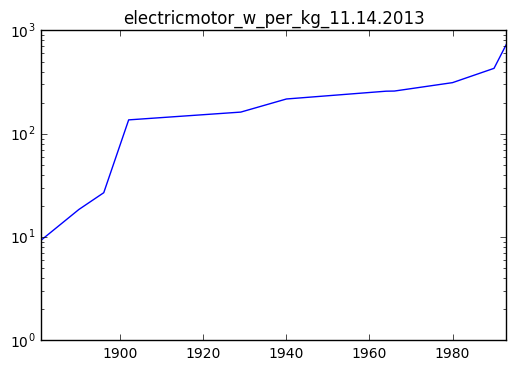

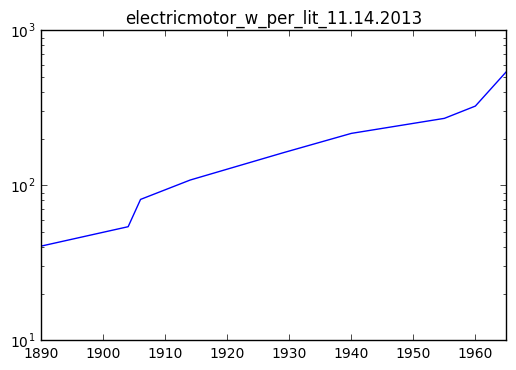

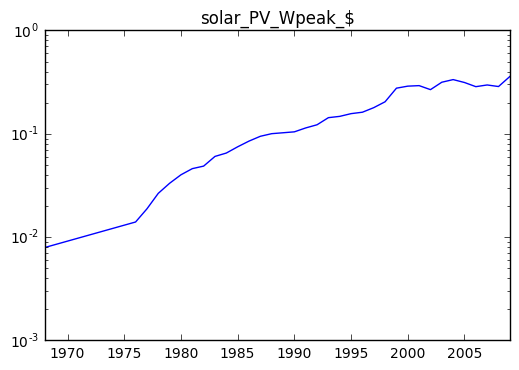

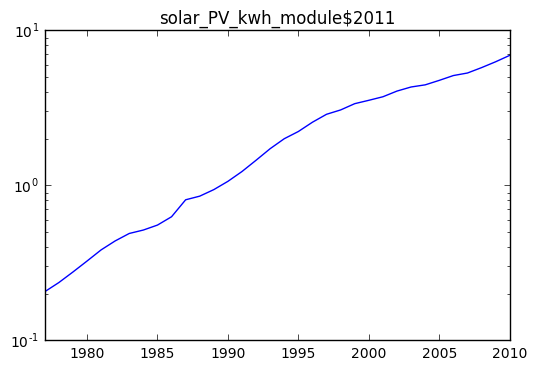

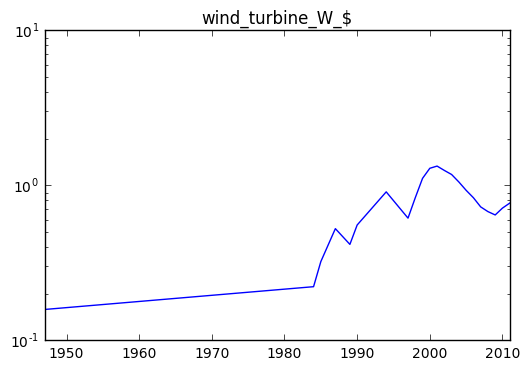

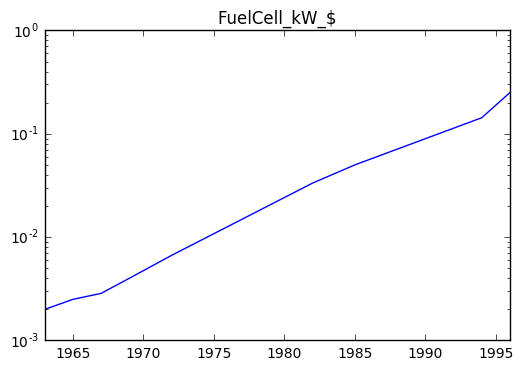

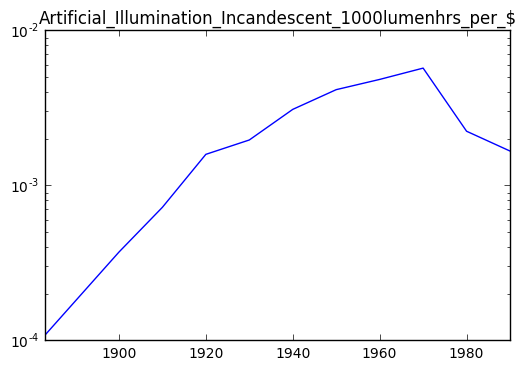

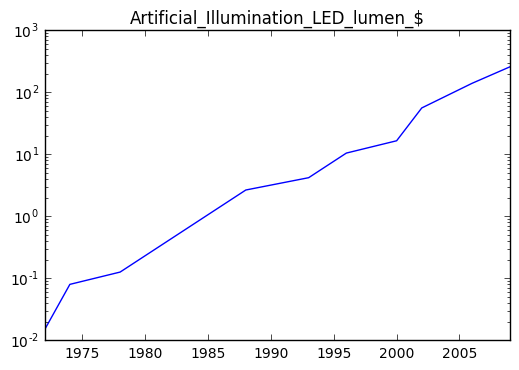

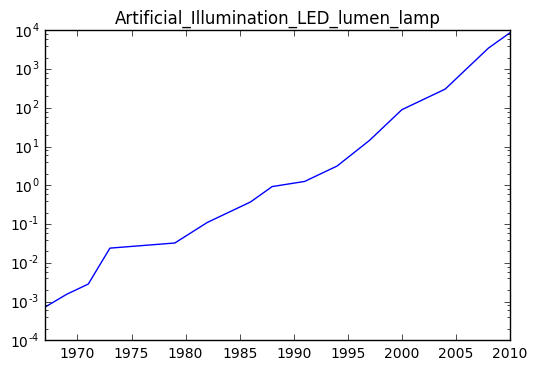

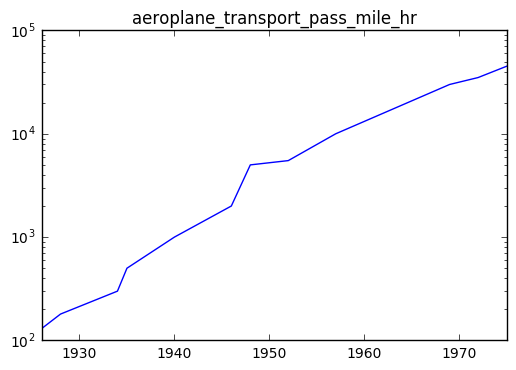

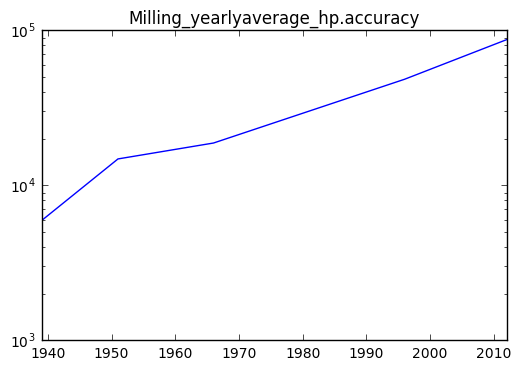

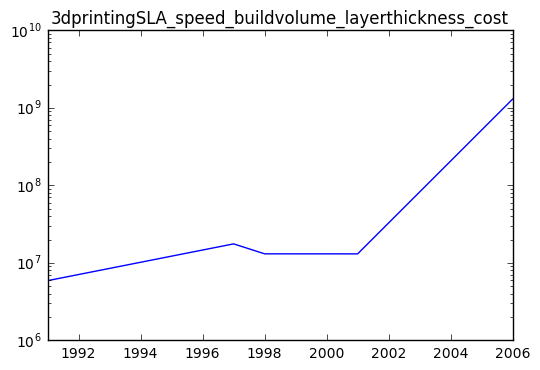

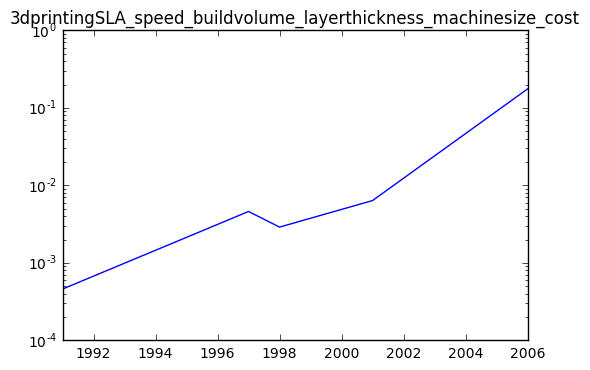

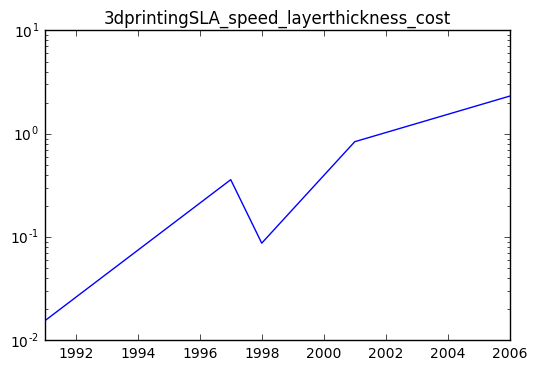

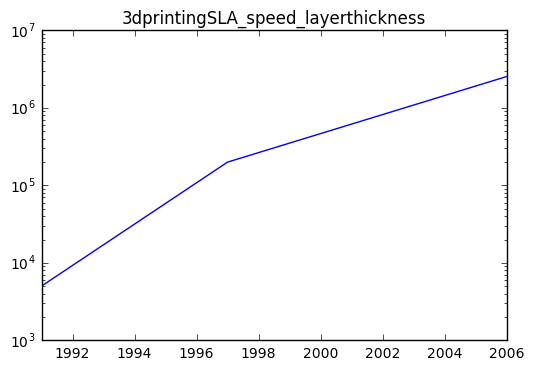

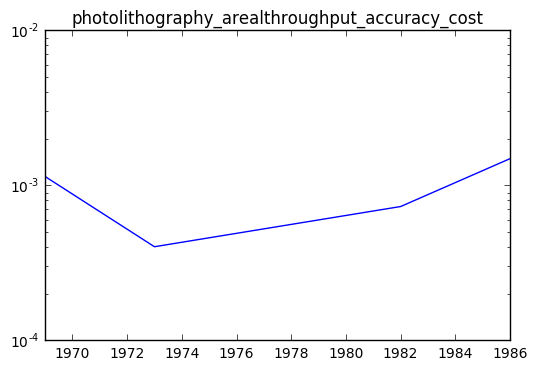

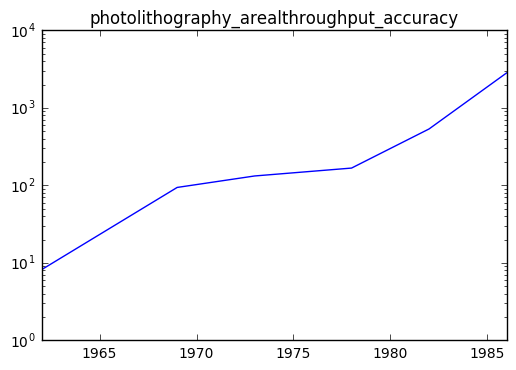

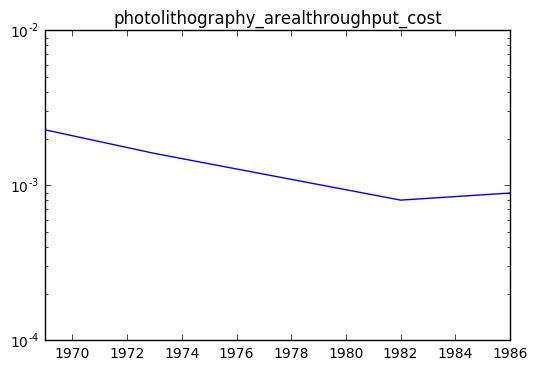

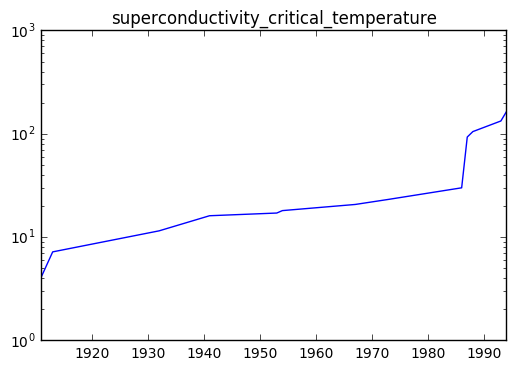

In [116]:
%pylab inline

for c in time_series.columns:
    figure()
    time_series[c].dropna().plot(legend=False)
    yscale('log')
    title(c)

In [117]:
time_series_metadata[time_series_metadata['Source']=='Farmer_Lafond'].shape

(66, 6)

In [118]:
time_series_metadata[time_series_metadata['Source']=='Magee_et_al'].shape

(64, 6)

In [119]:
sum(time_series_metadata[time_series_metadata['Source']=='Magee_et_al']['n']>10)

37